# Story's Analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

In [2]:
import cfod
from cfod import catalog
CHIME = catalog.as_dataframe()

# CHIME = pd.read_csv("./data/chimefrb.csv") #catalog from 07/14
CHIME

,tns_name,previous_name,repeater_name,ra,ra_err,ra_notes,dec,dec_err,dec_notes,gl,...,width_fitb,width_fitb_err,sp_idx,sp_idx_err,sp_run,sp_run_err,high_freq,low_freq,peak_freq,excluded_flag
0,FRB20180725A,180725.J0613+67,-9999,93.42,0.039,-9999,67.07,0.210,-9999,147.29,...,0.000296,0.000076,38.20,3.70,-45.80,4.20,760.1,485.3,607.4,1
1,FRB20180727A,180727.J1311+26,-9999,197.72,0.130,-9999,26.42,0.260,-9999,24.76,...,0.00139,0.000170,3.80,1.80,-9.20,3.00,800.2,400.2,493.3,1
2,FRB20180729A,180729.J1316+55,-9999,199.40,0.120,-9999,55.58,0.084,-9999,115.26,...,<0.00010,-9999.000000,16.46,0.24,-30.21,0.38,692.7,400.2,525.6,1
3,FRB20180729B,180729.J0558+56,-9999,89.93,0.270,-9999,56.50,0.240,-9999,156.90,...,0.000314,0.000083,14.50,3.50,-14.60,3.50,800.2,441.8,657.5,1
4,FRB20180730A,180730.J0353+87,-9999,57.39,0.032,-9999,87.19,0.200,-9999,125.11,...,0.000468,0.000040,4.27,0.30,-11.31,0.48,759.2,400.2,483.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,FRB20190701A,-9999,-9999,277.47,0.210,-9999,59.04,0.220,-9999,88.29,...,0.000608,0.000057,-1.10,1.50,3.30,1.90,800.2,400.2,800.2,0
596,FRB20190701B,-9999,-9999,302.93,0.220,-9999,80.18,0.240,-9999,112.88,...,0.00063,0.000130,3.90,1.70,-11.80,3.10,732.8,400.2,471.5,0
597,FRB20190701C,-9999,-9999,96.36,0.230,-9999,81.63,0.270,-9999,132.18,...,0.00144,0.000160,46.20,9.00,-211.00,41.00,495.5,402.2,446.4,0
598,FRB20190701D,-9999,-9999,112.10,0.180,-9999,66.70,0.160,-9999,149.28,...,0.00140,0.000120,6.49,0.75,-20.90,1.60,651.8,400.2,467.6,0


In [3]:
#### unpack FRB-cat1 data published by CHIME ####

snr, dm, low_ft_95, up_ft_95, flux, flux_err, fluence, fluence_err, = np.loadtxt(
    './data/chimefrbcat1.csv', skiprows=1, usecols=(17, 18, 21, 22, 31, 32, 34, 35), delimiter=',', unpack=True)

tns = np.loadtxt('./data/chimefrbcat1.csv', dtype='str', skiprows=1, usecols=(0), delimiter=',')
fluence_notes = np.loadtxt('./data/chimefrbcat1.csv', dtype='str', skiprows=1, usecols=36, delimiter=',')

## note: low_ft_95, up_ft_95, flux, flux_err, fluence_err never used
##       tns, fluence_notes are never used
## only snr, dm, fluence are relevant

#### define minimmum fluence for each event #####

MIN_SNR = 12 # approx. threshold, according to CHIME's cat1 paper
min_fluence = fluence * (MIN_SNR / snr) # scale reported fluence 'snr' by SNR ratio
del fluence_err, fluence_notes, flux, flux_err, tns, low_ft_95, up_ft_95

In [4]:
dm_new = np.array(CHIME['dm_fitb'])
snr_new = np.array(CHIME['snr_fitb'])
fluence_new = np.array(CHIME['fluence'])
MIN_SNR = 12
min_fluence_new = fluence_new * MIN_SNR/snr_new
del CHIME, snr_new, snr, MIN_SNR

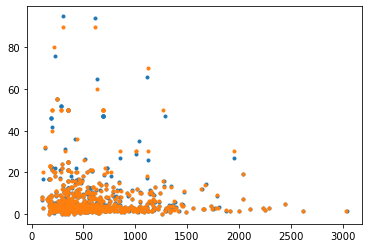

In [5]:
plt.scatter(dm_new, fluence_new, marker='.')
plt.scatter(dm, fluence, marker='.')

In [6]:
import sys
import os
sys.path.append(os.path.abspath("../frbfuncs/"))
import cosmology as c
# rs = c.z_DM(DM)

#K_MACQUART = 700/0.7 # approx. value of the proportionality constant linking redshift and dispersion
ISM = 30 # ansatz of interstellar medium's contribution to disperson, in pc cm-3
HALO = 50 # ansatz of MW's halo contribution to disperson, in pc cm-3

'''
function 'dm_ex' returns the extragalactic contribution to an FRB's total dispersion measure (dm_tot)
provided approx. values of the dispersion due to the interstellar medium (ISM) and the MW's halo (HALO)
'''
def dm_ex(dm_tot, dm_ism=30, dm_halo=50):
    return dm_tot - (dm_ism + dm_halo)

'''
function 'get_z' takes a dispersion measure and ansatz of the Macquart relation 
and returns corresponding redshift
'''
def get_z(dm):
    y = dm_ex(dm)
    return c.z_DM(y)

del ISM, HALO

In [7]:
rs = get_z(dm)
rs_new = get_z(dm_new)

In [8]:
lum = c.E_v(fluence, rs, alpha=1)
min_lum = c.E_v(min_fluence, rs, alpha=1)

lum_new = c.E_v(fluence_new, rs_new, alpha=1)
min_lum_new = c.E_v(min_fluence_new, rs_new, alpha=1)

# to match Story's code, multiply by 1e4/c.JYMS
del fluence, fluence_new, min_fluence, min_fluence_new

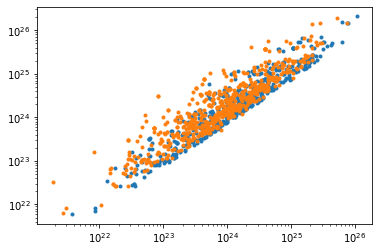

In [9]:
plt.scatter(min_lum, lum, marker='.')
plt.scatter(min_lum_new, lum_new, marker='.')
plt.yscale('log')
plt.xscale('log')
#plt.xlim([1e54, 1e60])
#plt.ylim([1e54, 1e60])

# Differences Thus Far
- ### different data sets
- DM function different: more sophisticated DM model, but I don't subtract 30 and 50 for ISM and HALO contributions
- get z from DM function different: mine is more sophisticated due to Arcus/Zhang DM model
- L and MIN_L have different units

In [10]:
def truncate_and_evolve(x, y, rs, evo=None):
    if evo is None:
        evo = np.ones(len(x))
    return x[y > x], y[y > x]/evo[y > x], evo[y > x], rs[y > x]

#min_lum_trunc, lum_trunc, evo_trunc, rs_trunc = truncate_and_evolve(min_lum, lum, rs)

In [11]:
### assign ranks to redshifts in increasing order ####    
def get_x_ranks(x, y, evo=None):
    if evo is None:
        evo = np.ones(len(x))
    
    x_inc = np.argsort(x)
    
    x_ranks = np.zeros(len(x))
    x_assoc_sets = np.zeros(len(x))
    
    # iterate through redshift array, find associated set for each: all lum > lum(event i) with rs < rs(event i)
    for i in range(len(x)):
        curr = x_inc[i] # current event being analyzed
        y_assoc = y[(y > x[curr]/evo[curr]) & (x < x[curr])] # iterate through luminosities, enforcing associated set constraints  
        x_assoc_sets[i] = len(y_assoc) # number of events in current associated set
        y_assoc = np.append(y_assoc, y[curr])
    
        args = np.argwhere(np.sort(y_assoc) == y[curr])
        if len(args) > 1:
            x_ranks[i] = np.average(args) + 1 #half considered below, half considered above
        else:
            x_ranks[i] = args[0,0] + 1 #include itself in rank
            
    return x_ranks, x_assoc_sets

#### construct arrays for ranks of each redshift, and associated set of each redshift ####

#x_ranks, x_assoc_sets = get_x_ranks(min_lum_trunc, lum_trunc)

In [12]:
def get_T(ranks, sets):
    rnks = ranks[sets > 0]
    ns = (sets+1)[sets > 0]
    return (rnks-(.5*(1+ns))) / (np.sqrt((ns**2 - 1) / 12))

def t_kendall(vec, w=None):
    if w is None:
        w = np.ones(len(vec)) # why +1??
    
    return np.sum(w*vec) / np.sqrt(np.sum(w**2))

In [13]:
#### function which enables luminosity evolution as function of redshift and critical redshift ####

def get_evos(x, g):
    x_cr = 3.5
    return np.piecewise(x, [x <= x_cr, x > x_cr], [lambda x: x**g, lambda x: x**g * (1 + x_cr**g) / (x**g + x_cr**g)])

#### function which computes the kendall statistic of a luminosity-evolution correction to CHIME cat1 ####

def kendall_evo(g, min_lum, lum, rs):
    
    Z = 1 + rs
    evos = get_evos(Z, g)
    
    x_evos, y_evos, evos_trunc, rs_trunc = truncate_and_evolve(min_lum, lum, rs, evo=evos)
    x_ranks, x_assoc_sets = np.array(get_x_ranks(x_evos, y_evos, evos_trunc))
    T = get_T(x_ranks, x_assoc_sets)
    
    return t_kendall(T)

In [14]:
g_space = np.linspace(2, 4.5, 20)
y = []
y_new = []

for val in g_space:
    y.append(kendall_evo(val, min_lum, lum, rs))
    y_new.append(kendall_evo(val, min_lum_new, lum_new, rs_new))

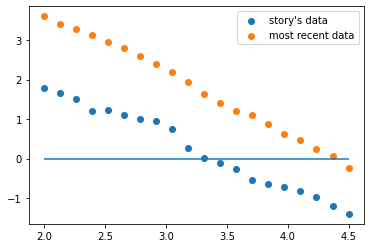

In [15]:
plt.scatter(g_space, y, label='story\'s data')
plt.scatter(g_space, y_new, label='most recent data')
plt.legend()
plt.hlines(0, 2.0, 4.5)
plt.show()

del g_space, y, y_new, val

# My Analysis

In [16]:
#variables

min_lum, lum, rs #story's data
min_lum_new, lum_new, rs_new #new data

print("data available")
min_lum

data available


array([2.11745235e+24, 1.75987644e+24, 1.30007463e+22, 1.41170741e+23,
       6.35761874e+24, 3.28216107e+24, 6.26432813e+24, 4.38777447e+23,
       4.30573461e+22, 5.11705881e+24, 3.76574650e+23, 3.76574650e+23,
       8.63655064e+22, 1.38296470e+25, 2.96319595e+23, 6.71393063e+23,
       2.87593300e+25, 1.82787490e+25, 3.08126243e+24, 1.63933452e+24,
       1.04452896e+24, 1.33420835e+24, 1.56731114e+23, 2.48919874e+23,
       1.50367070e+24, 1.80956299e+23, 8.84182331e+22, 9.65201498e+23,
       7.64405123e+22, 2.23682676e+23, 5.88823335e+23, 1.98497517e+25,
       7.34782133e+24, 8.82056172e+23, 8.82056172e+23, 8.82056172e+23,
       1.30250037e+25, 1.07739783e+24, 7.08970575e+22, 3.49603819e+24,
       5.92973914e+23, 4.86009427e+23, 1.92638839e+24, 3.67287583e+22,
       6.57109463e+22, 2.08397512e+22, 4.32922064e+24, 4.99616968e+23,
       2.17378116e+24, 5.95834126e+22, 1.19362523e+24, 2.09867346e+23,
       3.34672443e+23, 1.83809262e+24, 2.67894252e+24, 6.07842569e+24,
      

In [17]:
save_data = [min_lum, lum, rs]
save_data_new = [min_lum_new, lum_new, rs_new]
save_data

[array([2.11745235e+24, 1.75987644e+24, 1.30007463e+22, 1.41170741e+23,
        6.35761874e+24, 3.28216107e+24, 6.26432813e+24, 4.38777447e+23,
        4.30573461e+22, 5.11705881e+24, 3.76574650e+23, 3.76574650e+23,
        8.63655064e+22, 1.38296470e+25, 2.96319595e+23, 6.71393063e+23,
        2.87593300e+25, 1.82787490e+25, 3.08126243e+24, 1.63933452e+24,
        1.04452896e+24, 1.33420835e+24, 1.56731114e+23, 2.48919874e+23,
        1.50367070e+24, 1.80956299e+23, 8.84182331e+22, 9.65201498e+23,
        7.64405123e+22, 2.23682676e+23, 5.88823335e+23, 1.98497517e+25,
        7.34782133e+24, 8.82056172e+23, 8.82056172e+23, 8.82056172e+23,
        1.30250037e+25, 1.07739783e+24, 7.08970575e+22, 3.49603819e+24,
        5.92973914e+23, 4.86009427e+23, 1.92638839e+24, 3.67287583e+22,
        6.57109463e+22, 2.08397512e+22, 4.32922064e+24, 4.99616968e+23,
        2.17378116e+24, 5.95834126e+22, 1.19362523e+24, 2.09867346e+23,
        3.34672443e+23, 1.83809262e+24, 2.67894252e+24, 6.078425

In [18]:
def gfunction(x, g):
    x_cr = 3.5
    return np.piecewise(x+1, [x <= x_cr, x > x_cr], [lambda x: x**g, lambda x: x**g * (1 + x_cr**g) / (x**g + x_cr**g)])

def ktau_E(_y, _x, _z, _gfunc=gfunction, _k=0):
    
    _R = []
    _E = []
    _V = []
    _T = []
    
    gs = _gfunc(_z, _k)
    
    for i in range(len(_y)):
        higher = 0
        lower = 0
        
        if _y[i] <= _x[i]: #not considering data points under the cutoff
            continue
        
        for j in range(len(_y)): 
            if j == i or _y[j] <= _x[j]: #skip over itself, data points under cutoff
                continue
                
            if(_y[j]/gs[j] >= _x[i]/gs[i] and _x[j] <= _x[i]): #associated set requirements
                
                if(_y[j]/gs[j] > _y[i]/gs[i]):
                    higher += 1
                else:
                    lower += 1
        
        _N_i = higher+lower+1.
        _R_i = (lower+1.)/_N_i
        _E_i = (1.+1./_N_i)/2.
        _V_i = (1.-1./_N_i**2)/12.
        
        if _V_i == 0: #essentially, ignore points with only themselves in the associated set
            _V_i += 1
        
        _R.append(_R_i) #diagnostic print: print(f'loc: ({Es[i], z[i]}), high/low: {higher, lower}, rank: {R[len(R)-1]}')
        _E.append(_E_i) #0.5
        _V.append(_V_i) #1/12
        _T.append((_R_i-_E_i)/_V_i**0.5)
    
    return sum(_T)/(len(_T))**0.5

In [26]:
ktau_E(lum_new, min_lum_new, rs_new, _k=2)

3.692316340877592

In [27]:
g_space = np.linspace(2, 4.5, 20)
y = []
y_new = []

for val in g_space:
    y.append(ktau_E(lum, min_lum, rs, _k=val))
    y_new.append(ktau_E(lum_new, min_lum_new, rs_new, _k=val))

del val

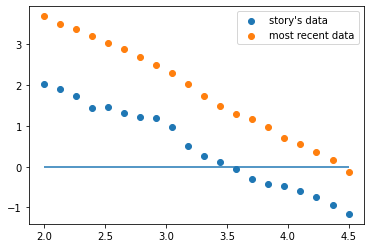

In [28]:
plt.scatter(g_space, y, label='story\'s data')
plt.scatter(g_space, y_new, label='most recent data')
plt.legend()
plt.hlines(0, 2.0, 4.5)
plt.show()